# Fraud Detection in Credit Card Transactions

## ======================
## 1. SETUP & DATA LOADING
## ======================

In [1]:
!pip install numpy pandas scikit-learn imbalanced-learn matplotlib seaborn xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline


## Load dataset

In [3]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

## 2. EXPLORATORY ANALYSIS

Dataset shape: (284807, 31)

Class distribution:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


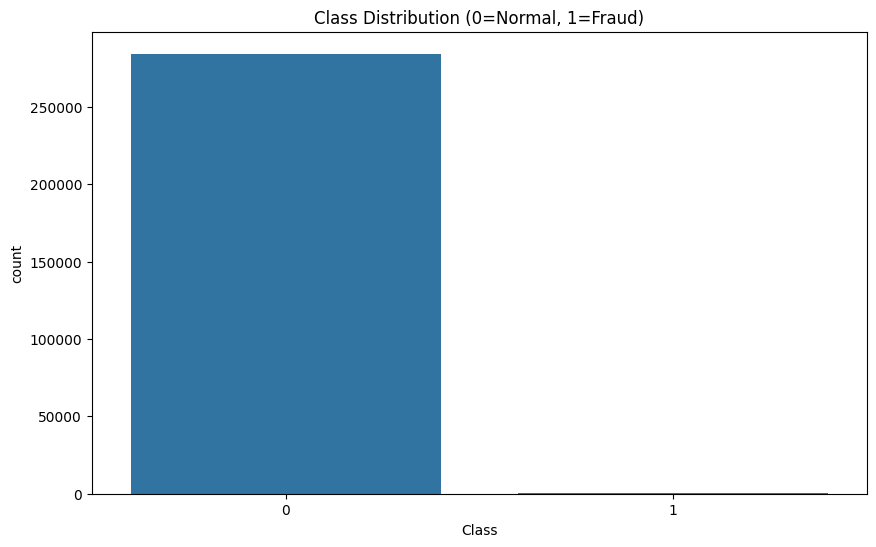

In [4]:
print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['Class'].value_counts(normalize=True)}")

plt.figure(figsize=(10,6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0=Normal, 1=Fraud)')
plt.show()

## 3. FEATURE ENGINEERING

In [5]:
# Normalize 'Amount' and drop 'Time'
df['Amount'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
df.drop('Time', axis=1, inplace=True)


## 4. HANDLING IMBALANCE

In [6]:

X = df.drop('Class', axis=1)
y = df['Class']

# Split before resampling to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE only to training data
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [7]:
# ======================
# 5. MODEL TRAINING
# ======================
# Random Forest with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_res, y_res)

# XGBoost with scale_pos_weight
xgb = XGBClassifier(scale_pos_weight=100, eval_metric='aucpr', random_state=42)
xgb.fit(X_res, y_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.81      0.84        98

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9603


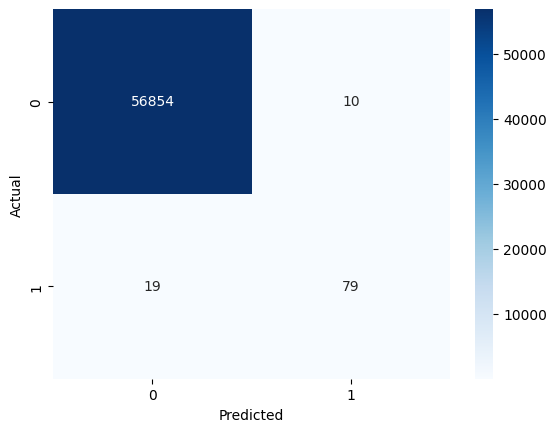


=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.64      0.86      0.73        98

    accuracy                           1.00     56962
   macro avg       0.82      0.93      0.86     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9788


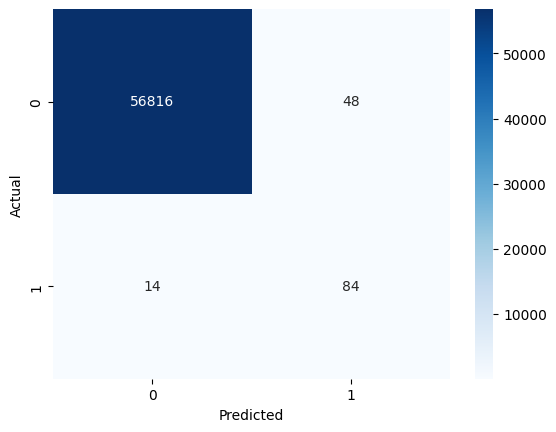

In [8]:

# ======================
# 6. MODEL EVALUATION
# ======================
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("=== Random Forest ===")
evaluate_model(rf, X_test, y_test)

print("\n=== XGBoost ===")
evaluate_model(xgb, X_test, y_test)


In [9]:

# ======================
# 7. THRESHOLD OPTIMIZATION
# ======================
from sklearn.metrics import precision_recall_curve

y_proba = xgb.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find threshold for 90% recall
target_recall = 0.9
threshold = thresholds[np.argmax(recall >= target_recall)]
print(f"Optimal threshold for {target_recall:.0%} recall: {threshold:.4f}")


Optimal threshold for 90% recall: 0.0000


In [10]:

# ======================
# 8. REAL-TIME PREDICTION
# ======================
def predict_fraud(transaction_data, model=xgb, threshold=0.5):
    """Predict fraud for new transaction"""
    proba = model.predict_proba(transaction_data)[0,1]
    return proba > threshold, proba

# Example usage
sample_transaction = X_test.iloc[[0]]  # Replace with new data
is_fraud, fraud_prob = predict_fraud(sample_transaction)
print(f"\nPrediction: {'Fraud' if is_fraud else 'Normal'}")
print(f"Probability: {fraud_prob:.4f}")


Prediction: Normal
Probability: 0.0000
